# Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2 
import os
import glob as gb 
from tqdm.auto import tqdm 

from sklearn.model_selection import train_test_split 

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Model
from tensorflow.keras import layers 
from tensorflow.keras.layers import Conv2D , MaxPooling2D , BatchNormalization , Conv2DTranspose , UpSampling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import Precision, Recall

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
tf.test.is_gpu_available()

True

In [5]:
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')

# Data Pipeline

In [6]:
IMG_SIZE = 256
BATCH_SIZE = 32 
BUFFER_SIZE = 1000
IMG_DIR = '/kaggle/input/ham1000-segmentation-and-classification/images'
MASK_DIR = '/kaggle/input/ham1000-segmentation-and-classification/masks'

In [7]:
def img_mask_paths(img_dir , mask_dir) : 
    imgs_path = sorted(gb.glob(os.path.join(img_dir , '*.jpg')))
    masks_path = sorted(gb.glob(os.path.join(mask_dir , '*.png')))
    
    imgs_path = np.array(imgs_path) 
    masks_path = np.array(masks_path) 
    
    return imgs_path , masks_path

In [8]:
imgs_path , masks_path = img_mask_paths(IMG_DIR , MASK_DIR)

In [9]:
x_train , x_test , y_train , y_test = train_test_split(imgs_path , masks_path , train_size = 0.80)

In [10]:
len(x_train) , len(x_test)

(8012, 2003)

In [11]:
def map_fn(img_path , mask_path) : 
    img = tf.io.read_file(img_path) 
    img = tf.image.decode_jpeg(img , channels = 3) 
    img = tf.image.resize(img , (IMG_SIZE , IMG_SIZE))
    img = tf.cast(img , tf.float32) / 255. 
    
    mask = tf.io.read_file(mask_path) 
    mask = tf.image.decode_jpeg(mask , channels = 1) 
    mask = tf.image.resize(mask , (IMG_SIZE , IMG_SIZE))
    mask = tf.cast(mask , tf.float32) / 255.
    
    return img , mask

In [12]:
train_set = tf.data.Dataset.from_tensor_slices((x_train , y_train))
train_set = train_set.map(map_fn , num_parallel_calls=AUTOTUNE) 
train_set = train_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)

test_set = tf.data.Dataset.from_tensor_slices((x_test , y_test)) 
test_set = test_set.map(map_fn , num_parallel_calls=AUTOTUNE) 
test_set = test_set.batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)

In [13]:
print(f"the size of the train dataloader {len(train_set)} batches of {BATCH_SIZE}")

the size of the train dataloader 251 batches of 32


In [14]:
print(f"the size of the test dataloader {len(test_set)} batches of {BATCH_SIZE}")

the size of the test dataloader 63 batches of 32


In [15]:
img_sample , mask_sample = next(iter(train_set)) 
img_sample.shape , mask_sample.shape

(TensorShape([32, 256, 256, 3]), TensorShape([32, 256, 256, 1]))

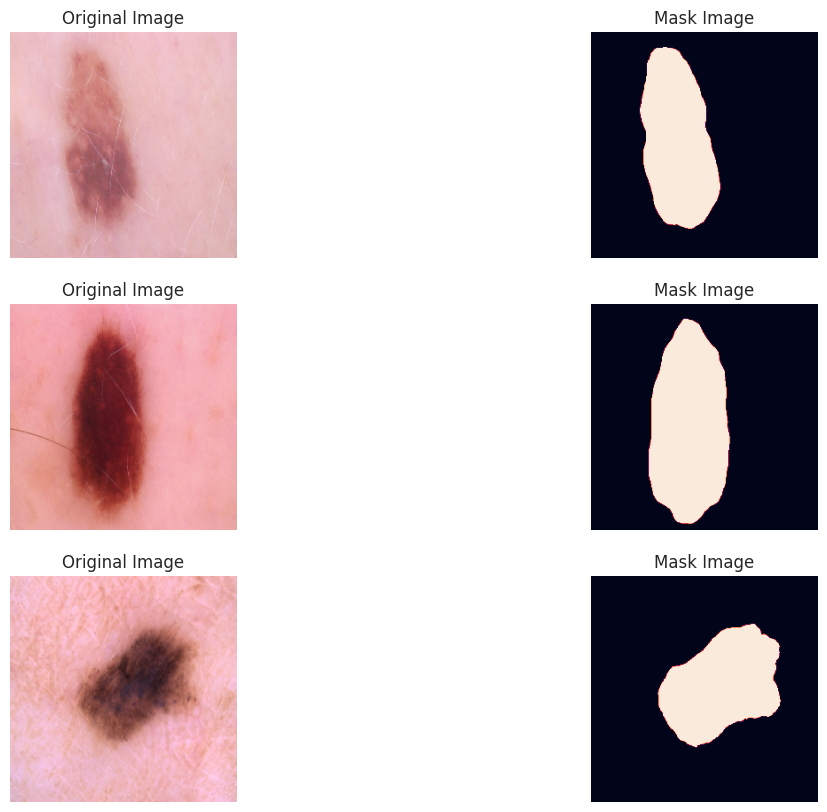

In [17]:
fig , axis = plt.subplots(3 , 2 , figsize = (15,10)) 
for i in range(3): 
    img1 = img_sample[i].numpy()
    axis[i, 0].imshow(img1)
    axis[i, 0].set(title = f"Original Image")
    axis[i, 0].axis('off')
    
    
    img2 = mask_sample[i].numpy()
    axis[i, 1].imshow(img2)
    axis[i, 1].set(title = f"Mask Image")
    axis[i, 1].axis('off')

plt.subplots_adjust(wspace=0.0)

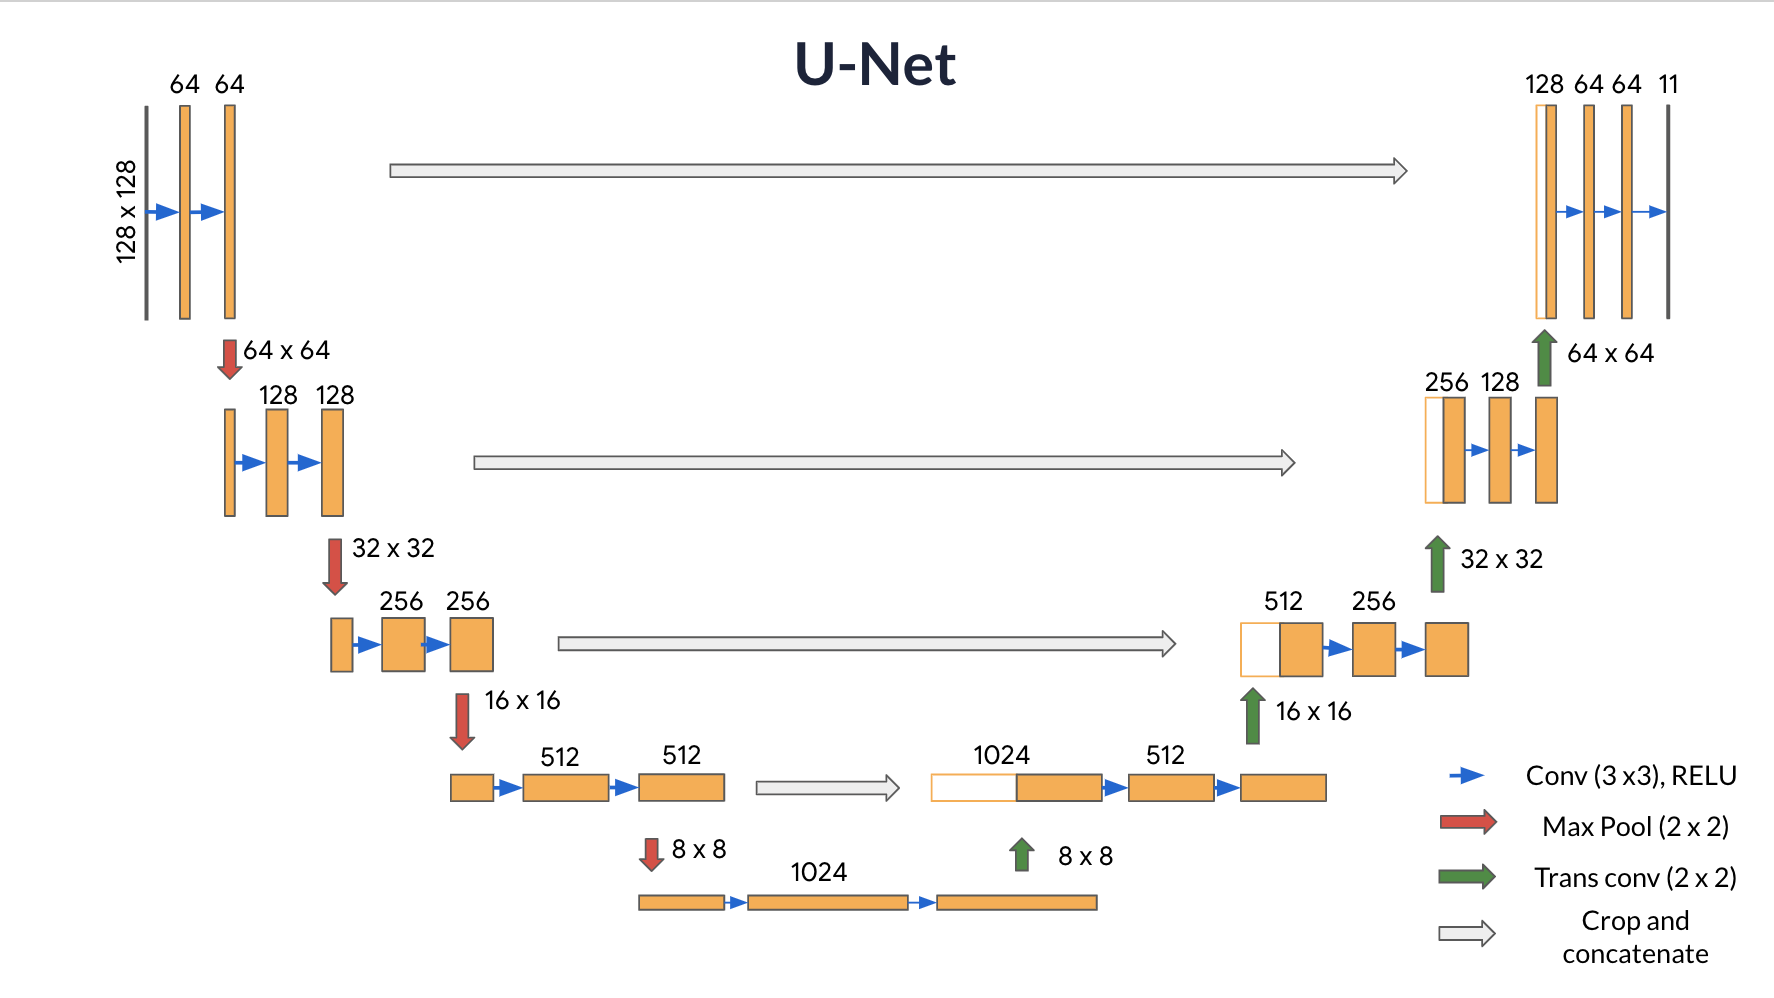

# Build our model

In [18]:
def UNET() : 
    inputs = keras.Input(shape = (IMG_SIZE , IMG_SIZE , 3))
    
    x = Conv2D(32, 3, strides=1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    skip_connections = [] 
    
    for filters in [64, 128, 256 , 512]:
        x = Conv2D(filters , 3 , strides = 1 , padding = 'same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = Conv2D(filters , 3 , strides = 1 , padding = 'same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        
        skip_connections.append(x)

        x = MaxPooling2D(2, strides=2, padding="same")(x)
        
    x = Conv2D(1024 , 3 , strides = 1 , padding = 'same')(x)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = Conv2D(1024 , 3 , strides = 1 , padding = 'same')(x)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    for filters in [512, 256 , 128 , 64] : 
        x = Conv2DTranspose(filters , 2 , strides = 2 , padding = "same")(x)
        skip_connection = skip_connections.pop()
        x = layers.add([x , skip_connection])
        
        x = Conv2D(filters , 3 , strides = 1 , padding = 'same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = Conv2D(filters , 3 , strides = 1 , padding = 'same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        
    outputs = Conv2D(1 , 1 , strides = 1 , activation = "sigmoid")(x)
        
    
    model = Model(inputs , outputs)
    
    return model

In [19]:
model = UNET()

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

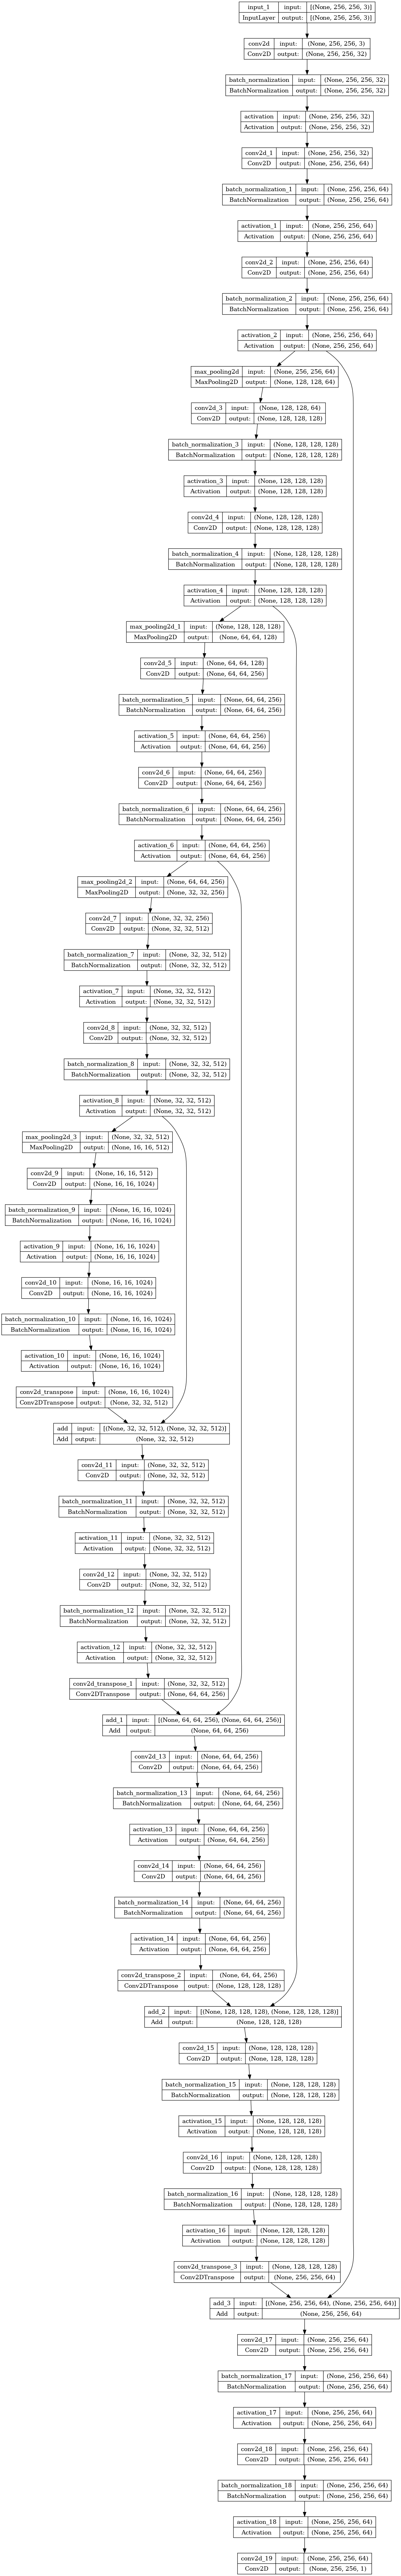

In [21]:
keras.utils.plot_model(model, show_shapes=True)

# Train our model 

In [22]:
model.compile(Adam(0.0002) , BinaryCrossentropy(), metrics=['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [23]:
with tf.device("/GPU:0") : 
    history = model.fit(
        train_set , 
        epochs = 10 , 
        batch_size = BATCH_SIZE , 
        validation_data = test_set , 
        workers = 8 , 
        use_multiprocessing = True
    )

Epoch 1/10
251/251 [==============================] - 233s 787ms/step - loss: 0.2200 - accuracy: 0.9164 - precision: 0.8643 - recall: 0.8269 - val_loss: 0.2489 - val_accuracy: 0.9004 - val_precision: 0.7960 - val_recall: 0.8531
Epoch 2/10
251/251 [==============================] - 191s 749ms/step - loss: 0.1465 - accuracy: 0.9433 - precision: 0.9192 - recall: 0.8743 - val_loss: 0.1720 - val_accuracy: 0.9322 - val_precision: 0.8576 - val_recall: 0.9014
Epoch 3/10
251/251 [==============================] - 191s 749ms/step - loss: 0.1308 - accuracy: 0.9480 - precision: 0.9263 - recall: 0.8854 - val_loss: 0.1381 - val_accuracy: 0.9471 - val_precision: 0.9049 - val_recall: 0.9023
Epoch 4/10
251/251 [==============================] - 191s 749ms/step - loss: 0.1234 - accuracy: 0.9502 - precision: 0.9310 - recall: 0.8889 - val_loss: 0.1524 - val_accuracy: 0.9389 - val_precision: 0.9041 - val_recall: 0.8671
Epoch 5/10
251/251 [==============================] - 192s 751ms/step - loss: 0.1157 - a

In [24]:
train_f1_score = (2 * history.history['precision'][-1] * history.history['recall'][-1]) / (history.history['precision'][-1] + history.history['recall'][-1])
test_f1score = (2 * history.history['val_precision'][-1] * history.history['val_recall'][-1]) / (history.history['val_precision'][-1] + history.history['val_recall'][-1])

In [25]:
print(f"The training loss is : {history.history['loss'][-1]:0.2f}\n")
print(f"The training accuracy is : {(history.history['accuracy'][-1]*100):0.2f}%\n")
print(f"The training precision is : {history.history['precision'][-1]:0.2f}\n")
print(f"The training recall is : {history.history['recall'][-1]:0.2f}\n")
print(f"The F1 score of the training set is : {train_f1_score:0.4f}\n")

The training loss is : 0.10

The training accuracy is : 95.89%

The training precision is : 0.94

The training recall is : 0.91

The F1 score of the training set is : 0.9265



In [26]:
print(f"The testing loss is : {history.history['val_loss'][-1]:0.2f}\n")
print(f"The testing accuracy is : {(history.history['val_accuracy'][-1]*100):0.2f}%\n")
print(f"The testing precision is : {history.history['val_precision'][-1]:0.2f}\n")
print(f"The testing recall is : {history.history['val_recall'][-1]:0.2f}\n")
print(f"The F1 score of the testing set is : {test_f1score:0.4f}\n")

The testing loss is : 0.11

The testing accuracy is : 95.74%

The testing precision is : 0.94

The testing recall is : 0.90

The F1 score of the testing set is : 0.9222



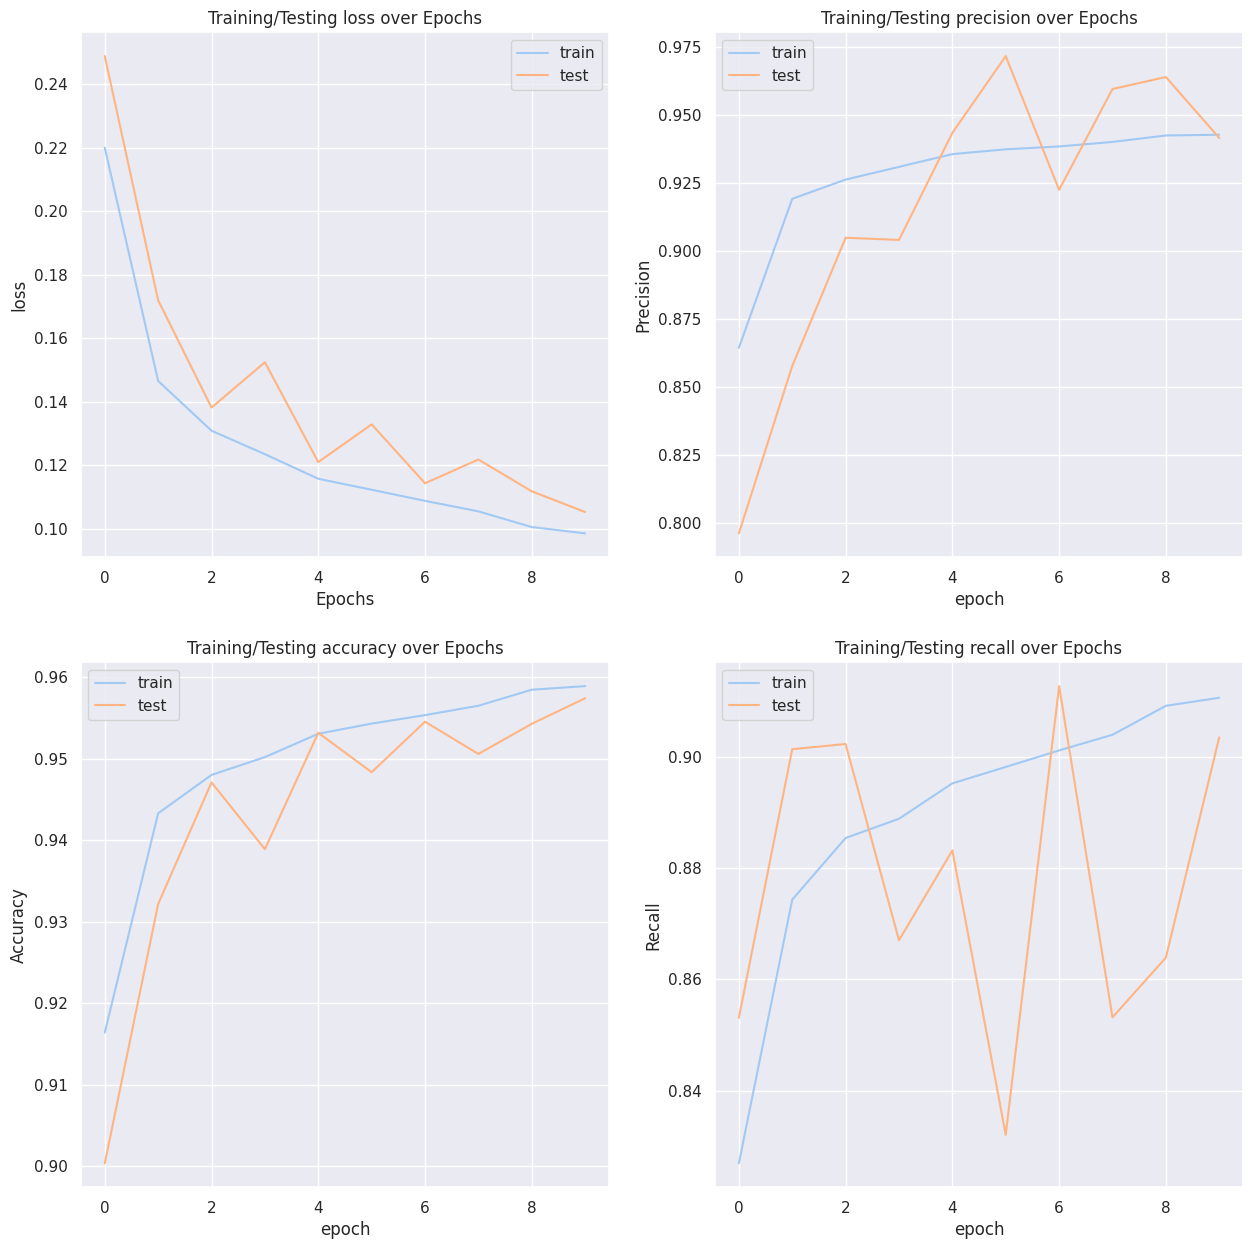

In [27]:
figure , axis = plt.subplots(2,2,figsize=(15,15))


axis[0,0].plot(history.history['loss'] , label='train')
axis[0,0].plot(history.history['val_loss'] , label='test')
axis[0,0].set_title('Training/Testing loss over Epochs')
axis[0,0].set_xlabel('Epochs')
axis[0,0].set_ylabel('loss')
axis[0,0].legend()


axis[1,0].plot(history.history['accuracy'], label='train')
axis[1,0].plot(history.history['val_accuracy'], label='test')
axis[1,0].set_title('Training/Testing accuracy over Epochs')
axis[1,0].set_xlabel('epoch')
axis[1,0].set_ylabel('Accuracy')
axis[1,0].legend()


axis[0,1].plot(history.history['precision'], label='train')
axis[0,1].plot(history.history['val_precision'], label='test')
axis[0,1].set_title('Training/Testing precision over Epochs')
axis[0,1].set_xlabel('epoch')
axis[0,1].set_ylabel('Precision')
axis[0,1].legend()


axis[1,1].plot(history.history['recall'], label='train')
axis[1,1].plot(history.history['val_recall'], label='test')
axis[1,1].set_title('Training/Testing recall over Epochs')
axis[1,1].set_xlabel('epoch')
axis[1,1].set_ylabel('Recall')
axis[1,1].legend()

# Make predictions

In [28]:
x_testsample , y_testsample = next(iter(test_set))

In [29]:
with tf.device("/GPU:0") : 
    y_pred = model.predict(x_testsample)

1/1 [==============================] - 0s 471ms/step


In [30]:
def draw(test_images , test_masks , y_preds):
    
    plt.figure(figsize = (20, 10))
    index = 0
    n = np.random.randint(y_preds.shape[0])
    for i in range(18):
        plt.subplot(3, 6, (i + 1))
        if index == 0:
            plt.imshow(test_images[n])
            plt.imshow(test_images[n])
            plt.title('Original Image')
            index = 1
            plt.axis('off')
        elif index == 1:
            plt.imshow(test_masks[n])
            plt.imshow(test_masks[n], alpha = 0.2, cmap = 'jet')
            plt.title('Original Mask')
            index = 2
            plt.axis('off')
        elif index == 2 : 
            plt.imshow(test_masks[n])
            plt.imshow(y_preds[n], alpha = 0.2, cmap = 'jet')
            plt.title('Predict Mask')
            index = 0
            n = np.random.randint(y_preds.shape[0])
            plt.axis('off')
        
            
    plt.legend()

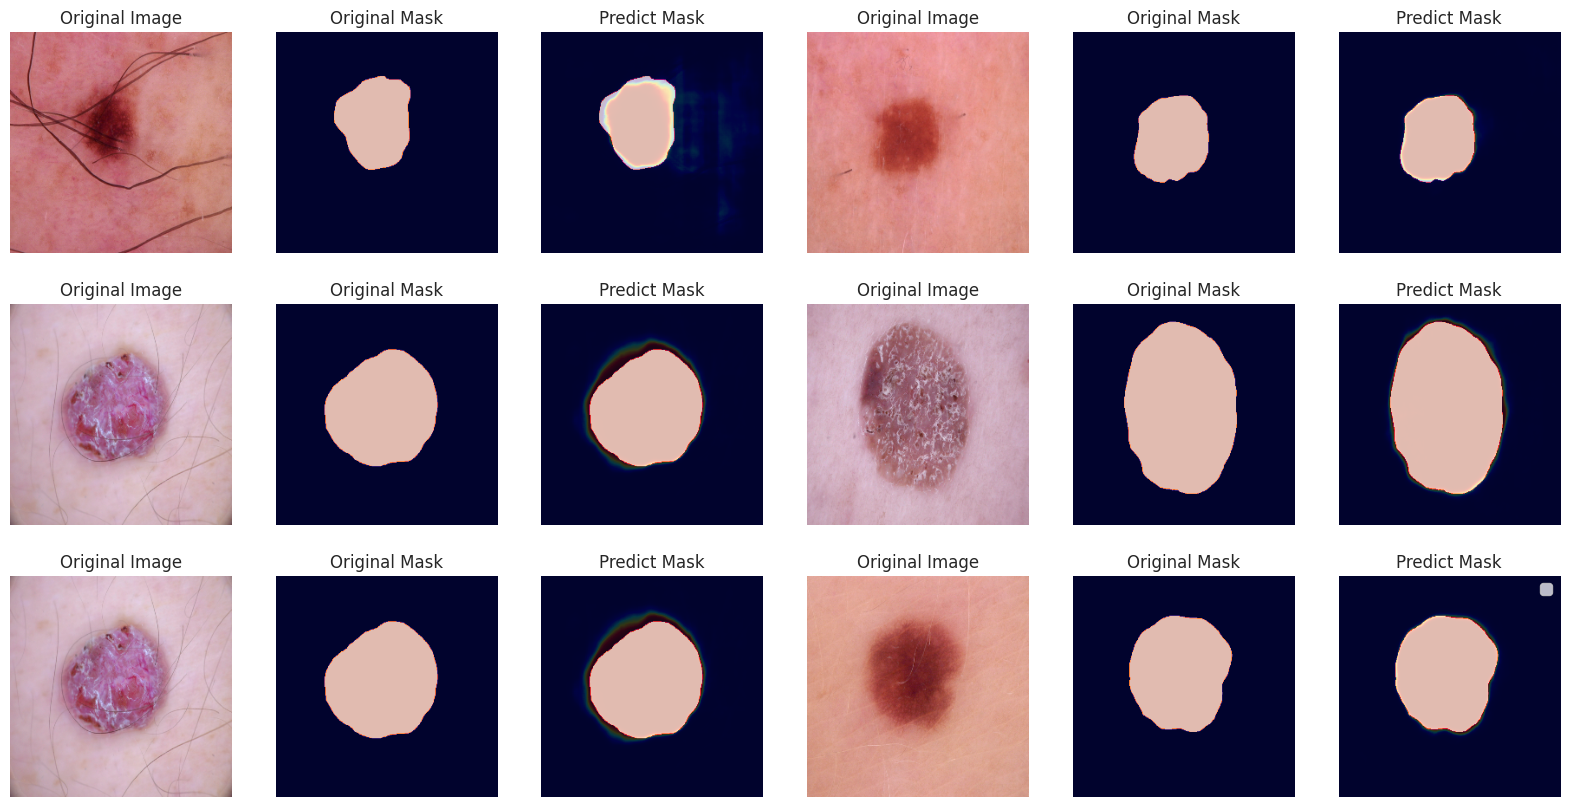

In [31]:
draw(x_testsample, y_testsample , y_pred)

# Save our model

In [32]:
model.save("Skin cancer Segmentation.h5")